In [33]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Load the datasets
class1_df = pd.read_csv('/content/drive/MyDrive/Bairing_issues/1716477046811_Imbalance.csv')
class2_df = pd.read_csv('/content/drive/MyDrive/Bairing_issues/1716477049033_Healthy.csv')
class3_df = pd.read_csv('/content/drive/MyDrive/Bairing_issues/1716477068984_1716477042847_Bearing_Fault.csv')

# Add class labels
class1_df['label'] = "imbalance"
class2_df['label'] = "healthy"
class3_df['label'] = "bearing_issues"

In [43]:
  # Assuming class1_df, class2_df, class3_df are already defined DataFrames
  df = pd.concat([class1_df, class2_df, class3_df], ignore_index=True)
  print(df.head())

        G1x      G1y       G1z      G2x       G2y      G2z       Vb1      Vb2  \
0  0.034018  0.18194 -0.051011  0.40813  0.048206  0.15618  0.000198  0.00331   
1  0.032407  0.10908 -0.029934 -0.39911 -0.023339  0.15131  0.000663  0.00270   
2  0.030508  0.19411 -0.085132  0.41700  0.029059  0.15085  0.001210  0.00259   
3  0.027678  0.15055  0.058802 -0.27273 -0.019793  0.14843  0.000693  0.00380   
4  0.026291  0.15064 -0.070481  0.20005  0.004126  0.14428  0.000224  0.00327   

        Ac1       AC2     Labels      label Lables  
0 -0.025905 -0.045303  Imbalance  imbalance    NaN  
1 -0.024261 -0.015056  Imbalance  imbalance    NaN  
2 -0.019987 -0.007165  Imbalance  imbalance    NaN  
3 -0.018672 -0.025576  Imbalance  imbalance    NaN  
4 -0.021302 -0.032809  Imbalance  imbalance    NaN  


In [44]:
# Drop columns with any NaN values
df = df.dropna(axis=1, how='any')

# Convert 'label' column to category and then to string
df['label'] = df['label'].astype('category').astype('str')
df['label'].astype('category')
df['label']=df['label'].astype('str')
df

<ipython-input-44-096984b80c2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype('category').astype('str')
<ipython-input-44-096984b80c2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label']=df['label'].astype('str')


,G1x,G1y,G1z,G2x,G2y,G2z,Vb1,Vb2,Ac1,AC2,label
0,0.034018,0.181940,-0.051011,0.408130,0.048206,0.156180,0.000198,0.00331,-0.025905,-0.045303,imbalance
1,0.032407,0.109080,-0.029934,-0.399110,-0.023339,0.151310,0.000663,0.00270,-0.024261,-0.015056,imbalance
2,0.030508,0.194110,-0.085132,0.417000,0.029059,0.150850,0.001210,0.00259,-0.019987,-0.007165,imbalance
3,0.027678,0.150550,0.058802,-0.272730,-0.019793,0.148430,0.000693,0.00380,-0.018672,-0.025576,imbalance
4,0.026291,0.150640,-0.070481,0.200050,0.004126,0.144280,0.000224,0.00327,-0.021302,-0.032809,imbalance
...,...,...,...,...,...,...,...,...,...,...,...
8989,-0.096900,-1.494300,0.771300,0.094400,1.686000,0.927400,-0.082400,0.48970,0.037219,0.009602,bearing_issues
8990,-0.110900,-0.454800,0.968000,-0.504400,1.496900,0.857600,-0.438000,-0.80270,0.035575,0.010917,bearing_issues
8991,0.156500,0.713500,1.070200,-0.099900,1.216700,0.635600,-0.131900,-0.53270,0.031959,0.010917,bearing_issues
8992,0.774000,0.970900,0.841900,-0.121300,1.577700,1.156100,0.263700,-0.14150,0.028013,0.011246,bearing_issues


In [45]:
# Separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [49]:
# Reshape X for LSTM input (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

In [50]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

In [51]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
900/900 - 6s - loss: 1.2012e-08 - accuracy: 1.0000 - val_loss: 1.5313e-07 - val_accuracy: 1.0000 - 6s/epoch - 6ms/step
Epoch 2/10
900/900 - 5s - loss: 1.3807e-05 - accuracy: 1.0000 - val_loss: 7.3420e-04 - val_accuracy: 0.9994 - 5s/epoch - 5ms/step
Epoch 3/10
900/900 - 5s - loss: 3.3137e-11 - accuracy: 1.0000 - val_loss: 7.1639e-04 - val_accuracy: 0.9994 - 5s/epoch - 6ms/step
Epoch 4/10
900/900 - 5s - loss: 3.9764e-10 - accuracy: 1.0000 - val_loss: 4.8722e-04 - val_accuracy: 0.9994 - 5s/epoch - 6ms/step
Epoch 5/10
900/900 - 5s - loss: 5.7491e-09 - accuracy: 1.0000 - val_loss: 4.1915e-06 - val_accuracy: 1.0000 - 5s/epoch - 5ms/step
Epoch 6/10
900/900 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.1894e-06 - val_accuracy: 1.0000 - 6s/epoch - 6ms/step
Epoch 7/10
900/900 - 5s - loss: 1.8225e-10 - accuracy: 1.0000 - val_loss: 3.5905e-06 - val_accuracy: 1.0000 - 5s/epoch - 5ms/step
Epoch 8/10
900/900 - 5s - loss: 9.6375e-07 - accuracy: 1.0000 - val_loss: 2.1472e-07 - val

In [61]:
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')

Train Loss: 0.0
Train Accuracy: 1.0


In [59]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


Test Loss: 0.0005788148264400661
Test Accuracy: 0.9994441270828247


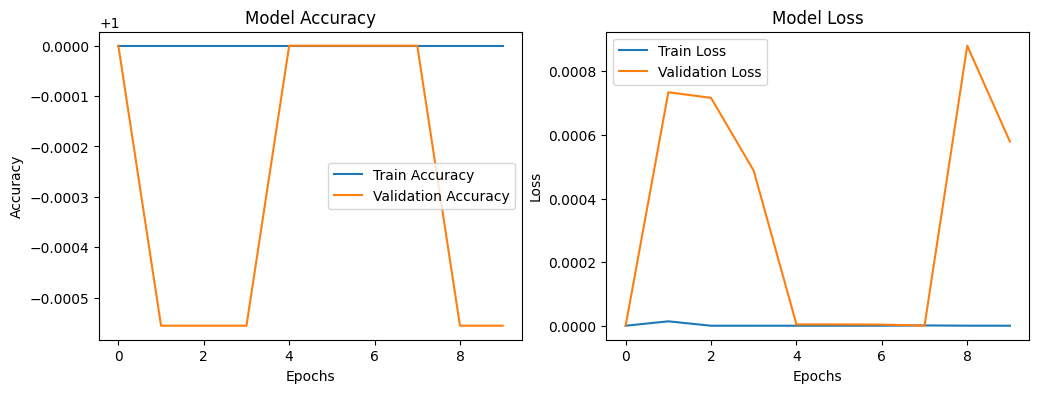

In [62]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [68]:
# Example of a new input data
new_input = np.array([[0.0056 ,	1.7307 , 1.2078 ,	0.1989 ,	1.2842 ,	1.2517 ,	-0.2941 ,	-0.6041 ,	-0.011439 ,	-0.036097]])

# Preprocess the new input data (scaling and reshaping)
new_input_scaled = scaler.transform(new_input)
new_input_reshaped = new_input_scaled.reshape((new_input_scaled.shape[0], 1, new_input_scaled.shape[1]))

# Predict the label for the new input data
prediction = model.predict(new_input_reshaped)
predicted_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))

print(f"Predicted label for the input data: {predicted_label[0]}")


1/1 [==============================] - 0s 27ms/step
Predicted label for the input data: bearing_issues
